Charger l'image.

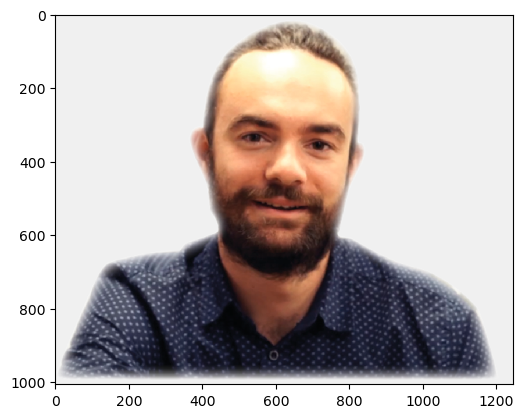

In [1]:
import skimage as ski
import matplotlib.pyplot as plt

image = ski.io.imread("nicolas.png")

plt.imshow(image, interpolation="none")

Filtre bilatéral

In [2]:
#image = ski.restoration.denoise_bilateral(image, sigma_color=0.05, sigma_spatial=5, channel_axis=-1)
#plt.imshow(image)

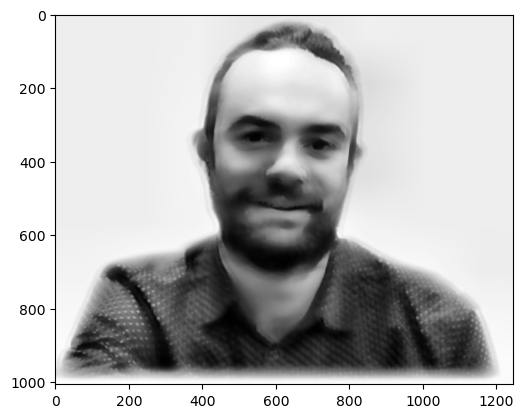

In [3]:
image = ski.restoration.denoise_bilateral(image, sigma_color=0.05, sigma_spatial=5, channel_axis=-1)
image = ski.exposure.equalize_adapthist(image)

image = ski.color.rgb2gray(image)

plt.imshow(image, cmap="gray")

array([0.33288153, 0.7027499 ])

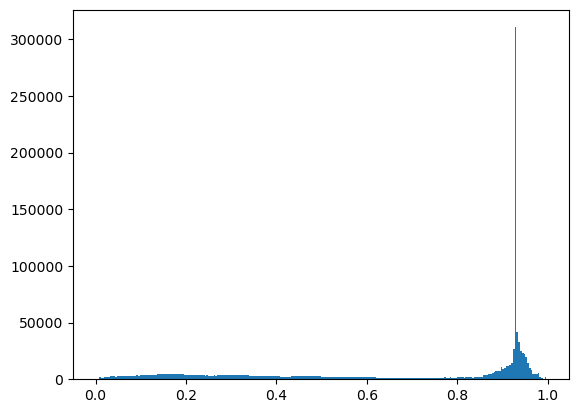

In [4]:
import numpy as np
hist = plt.hist(image.ravel(),bins=256)
histo = np.array(hist[0])
maximum=histo.argmax()/256
thresholds = ski.filters.threshold_multiotsu(image)
thresholds


Trouver les bords de l'image.

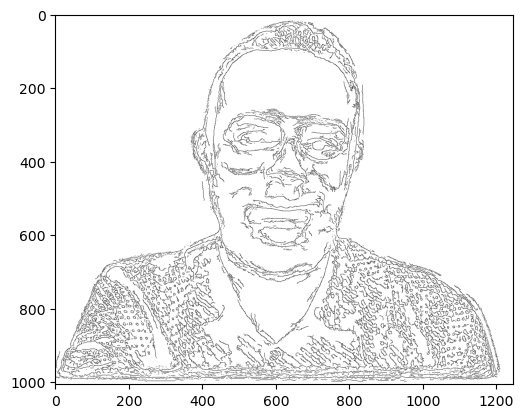

In [15]:
edge_image = ski.feature.canny(image, sigma=0.1, low_threshold = 0, high_threshold=0.1)
plt.imshow(1 - edge_image, cmap="gray")


Regrouper les bords de l'image en composantes connexes.

In [6]:
#harris_image = ski.feature.corner_harris(image)
#equalized_harris = ski.exposure.equalize_hist(harris_image)
#plt.imshow(equalized_harris, cmap="gray")

In [7]:
#import numpy as np

#corner_peaks = ski.feature.corner_peaks(harris_image, threshold_rel=0.01)

#plt.imshow(image, cmap="gray")
#corners = np.array(corner_peaks).T
#print(corners)
#plt.scatter(corners[1], corners[0])

In [8]:
# from edge_walker import group_edges

# edge_groups = group_edges(equalized_harris, 0.2)
# print(len(edge_groups))
# for edge in edge_groups:
#     plt.plot(edge.T[0], edge.T[1])

2897


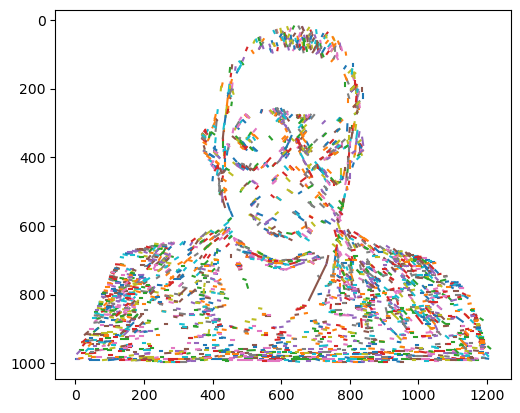

In [16]:
import numpy as np
hough_lines = ski.transform.probabilistic_hough_line(edge_image, line_length=6, line_gap=2, threshold=20)
hough_lines = np.array(hough_lines)

print(len(hough_lines))

# hough_lines = hough_lines/max(image.shape[0], image.shape[1])

plt.gca().invert_yaxis()
for line in hough_lines:
    p0, p1 = line
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]))
plt.gca().set_aspect('equal')

In [10]:
# import pickle

# with open("tomcruise.pkl", "wb") as f:
#     pickle.dump(hough_lines,f)
#     f.close()


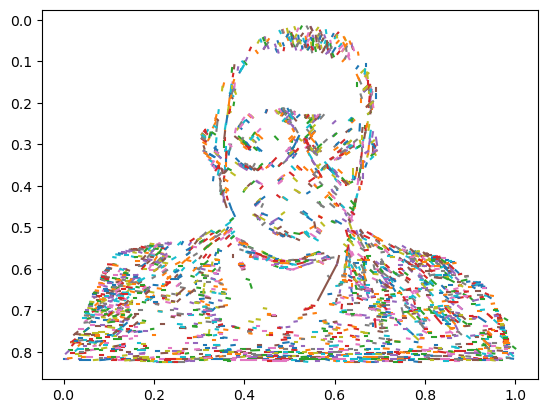

In [17]:
from numpy import linalg as LA 
data = hough_lines/np.max(hough_lines)
threshold = 0.01
plt.figure()
for seg in data:

    plt.plot(seg.T[0],seg.T[1])
    plt.gca().invert_yaxis()



data=list(data)
new_data=[[data[0]]]
id_group = 0
id_=0
for id_line in range(len(data)):
    if len(data)>1:
        dmin=LA.norm(data[0][1]-data[1][0])
        id_min=0
        for id_seg in range(len(data)):
            d=LA.norm(new_data[id_group][id_][1]-data[id_seg][0])
            if d<=dmin:
                id_min = id_seg
                dmin=d
    else:
        id_min=0
    id_+=1
    if dmin>threshold:
        id_group+=1
        id_=0
        new_data.append([])
    new_data[id_group].append(data[id_min])
    
    data.pop(id_min)

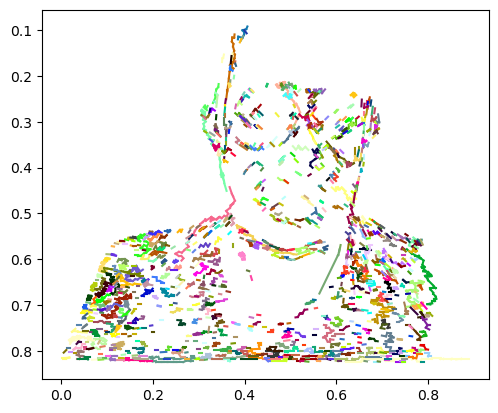

In [18]:
import matplotlib.colors as mcolors
cs = mcolors.XKCD_COLORS

plt.gca().invert_yaxis()
for c, line_group in zip(cs, new_data):
    preceding_line = None
    for line in line_group:
        p0, p1 = line
        if preceding_line is not None:
            n0, n1 = preceding_line
            plt.plot((n1[0], p0[0]), (n1[1], p0[1]), c=c)
        preceding_line = line
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]), c=c)
plt.gca().set_aspect('equal')

<Axes: ylabel='Count'>

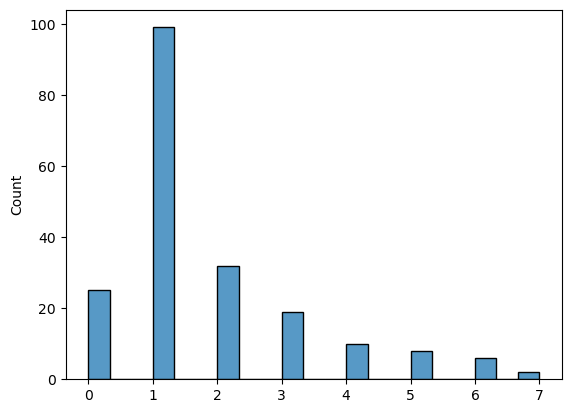

In [13]:
from numpy import arctan

def angle(line):
    p0, p1 = line
    if p1[0] - p0[0] != 0:
        return arctan((p1[1] - p0[1])/(p1[0] - p0[0]))
    elif p1[1] - p0[1] < 0:
        return -np.pi/2
    else:
        return np.pi/2

slope_threshold = np.pi/3

new_groups = []
uptos = []
angles = []

for line_group in new_data:
    new_groups.append([])
    for i in range(len(line_group) - 1):
        upto = 0
        angles.append(abs(angle(line_group[i]) - angle(line_group[i+upto+1])))
        while i+upto+1 < len(line_group) and abs(angle(line_group[i]) - angle(line_group[i+upto+1])) < slope_threshold:
            upto+=1
        uptos.append(upto)
        new_groups[-1].append((line_group[i][0], line_group[i+upto][1]))
        i += upto

uptos = np.array(uptos)
angle_diffs =np.array(angles)
import seaborn
seaborn.histplot(uptos)

201

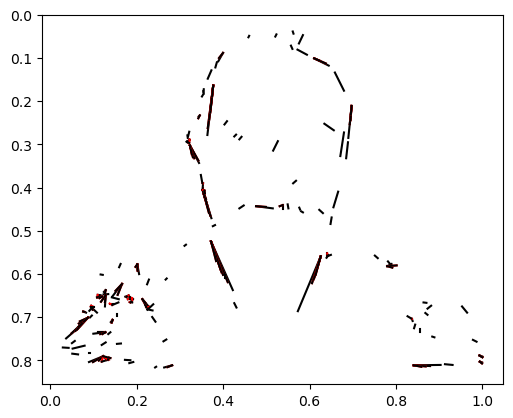

In [14]:
total = 0

plt.gca().invert_yaxis()
for line_group in new_groups:
    preceding_line = None
    for line in line_group:
        total += 1
        p0, p1 = line
        if preceding_line is not None:
            n0, n1 = preceding_line
            plt.plot((n1[0], p0[0]), (n1[1], p0[1]), c=(1,0,0))
        preceding_line = line
        plt.plot((p0[0], p1[0]), (p0[1], p1[1]), c=(0,0,0))
plt.gca().set_aspect('equal')

total